In [1]:
from PIL import Image
image = Image.open('./pkm/all/001.png')

In [2]:
image.size

(400, 400)

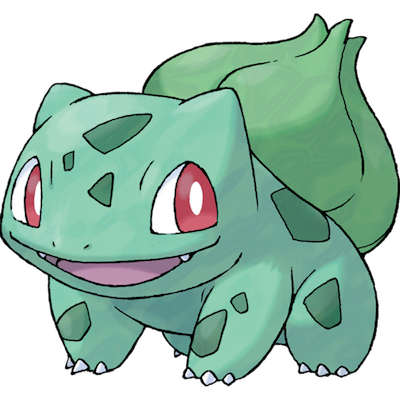

In [3]:
image

# Settings

In [4]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [5]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# Dataset loading

In [6]:
dataset_name='pokemon'

In [7]:
IMG_DIR = './pkm/'
VAL_PCT = 0
VAL_FORMAT = 'png'

In [8]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [9]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in 'all'


  INFO     | 4 file found


  WARNING  | Folder has less than 20 images, which may cause issues.
..\..\..\training\generators\file_image_generator.py:91: UserWarning: Folder has less than 20 images, which may cause issues.
  warnings.warn(msg)


In [10]:
inputs_shape= IMG_SIZE=(200, 200, 3)
BATCH_SIZE = 1
latent_dim = 100
intermediate_dim = 100

In [11]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode=None
)

  INFO     | Found 4 training files


  INFO     | Found 0 validation files


In [12]:
from utils.augmentation.augmentor import operations, do_operation

In [13]:
str(operations[0]())

'Skew'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [15]:
batch = next(train_gen)
batch = next(train_gen)

operation Skew ===================


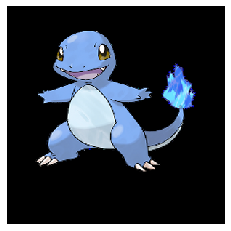

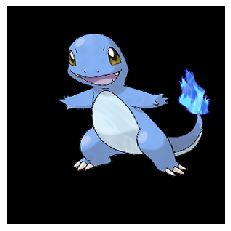

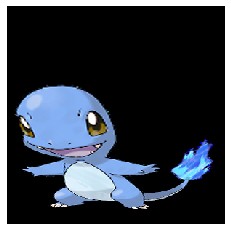

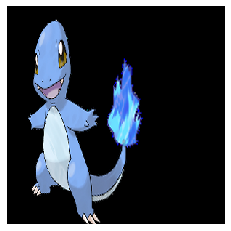

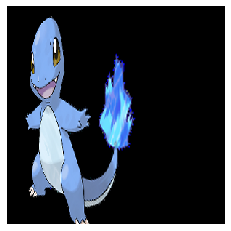

In [16]:
i = 0
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Distort ===================


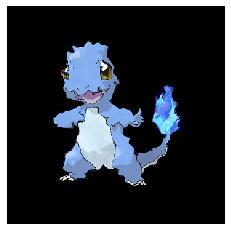

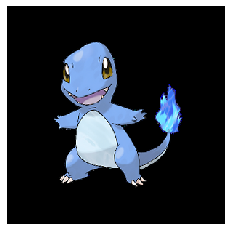

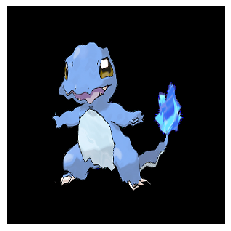

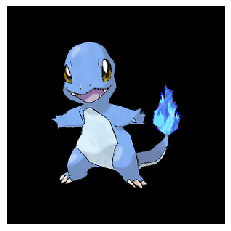

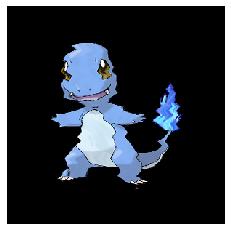

In [17]:
i = 1
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Rotate 82 ===================


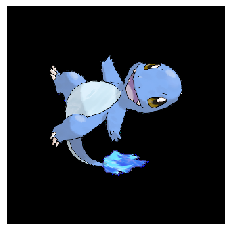

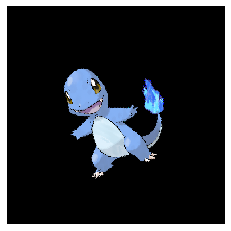

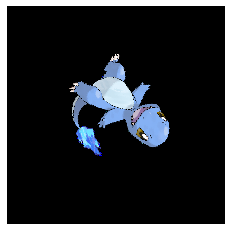

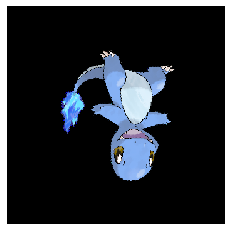

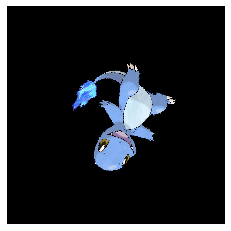

In [18]:
i = 2
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Shear ===================


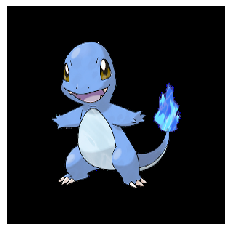

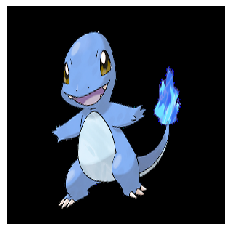

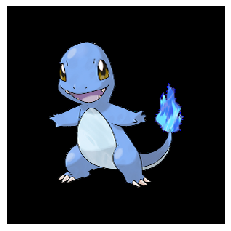

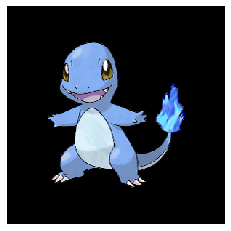

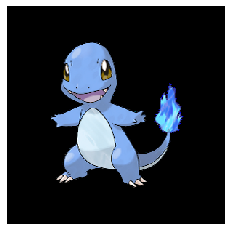

In [19]:
i = 3
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Zoom ===================


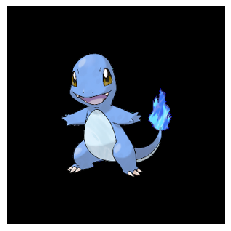

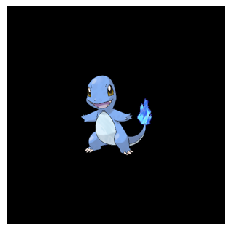

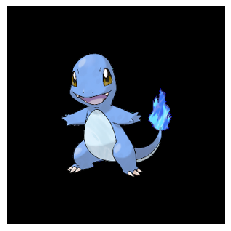

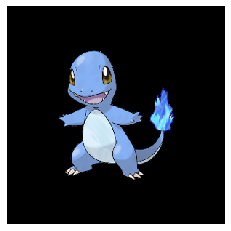

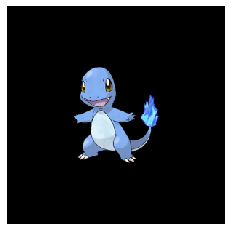

In [20]:
i = 4
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Colorize ===================


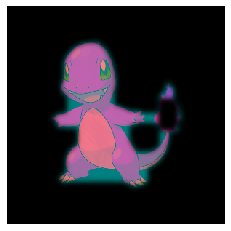

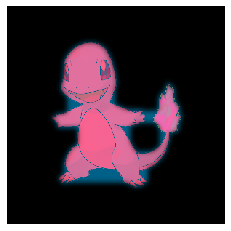

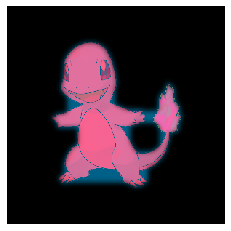

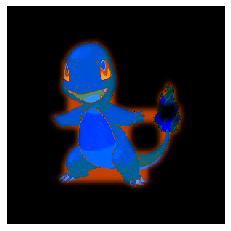

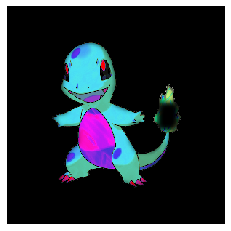

In [21]:
i = 5
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Skitch ===================


..\..\..\utils\augmentation\Skitcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
  result = front * 255 / (255 - back)


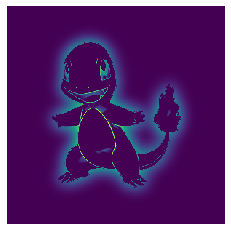

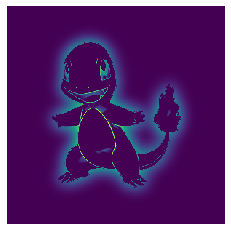

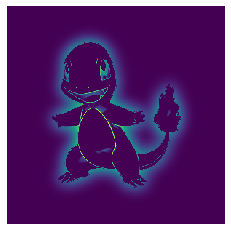

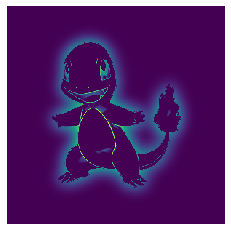

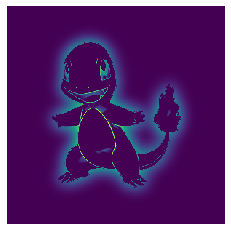

In [22]:
i = 6
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

operation Clone ===================


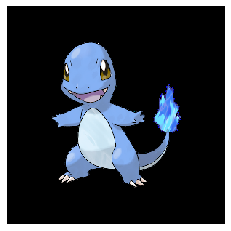

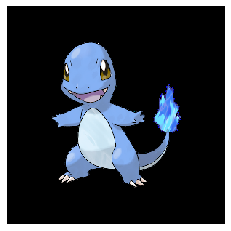

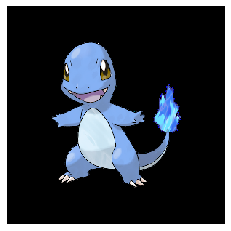

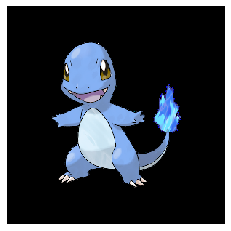

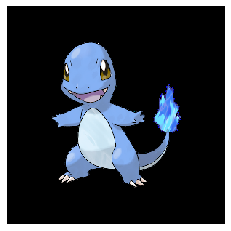

In [23]:
i = 7
for image in batch:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, image)
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()